In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from itertools import cycle
#  from scipy import interp


In [2]:
# Load preprocessed TF-IDF features
df_tfidf = pd.read_pickle('tfi.pkl')
df_ngr = pd.read_pickle('ngr.pkl')
df_lda = pd.read_pickle('lda.pkl')
df_bow = pd.read_pickle('bow.pkl')
#print(df_tfidf)

In [4]:

#Use tfidf as first dataset
X = df_tfidf.drop(['num_label'], axis=1).values
y = df_tfidf['num_label'].values

# Binarize the labels for ROC-AUC
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Define the parameter grid for grid search
param_grid = {
    'alpha': [0.0001, 0.001],
    'loss': ['log_loss'],
    'penalty': ['l2', 'l1'],
    'max_iter': [1000],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['constant', 'optimal'],
    'eta0': [0.01, 0.1]
}

# Create SGD classifier with log loss (for probabilities)
sgd = SGDClassifier(random_state=42)

# Set up 10-fold cross-validated grid search
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=sgd, param_grid=param_grid, 
                          cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Perform grid search
print("Performing grid search...")
grid_search.fit(X, y)

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best estimator
best_sgd = grid_search.best_estimator_


Performing grid search...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Best parameters found:
{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}

Best cross-validation accuracy: 0.9410


In [6]:
from sklearn.model_selection import cross_val_predict
X = df_tfidf.drop(['num_label'], axis=1).values
y = df_tfidf['num_label'].values
print("\nClassification report with best estimator (10-fold CV):")
y_pred = cross_val_predict(best_sgd, X, y, cv=cv)
print(classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, [f"Class {i}" for i in range(5)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(5)])

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



Classification report with best estimator (10-fold CV):


NameError: name 'best_sgd' is not defined

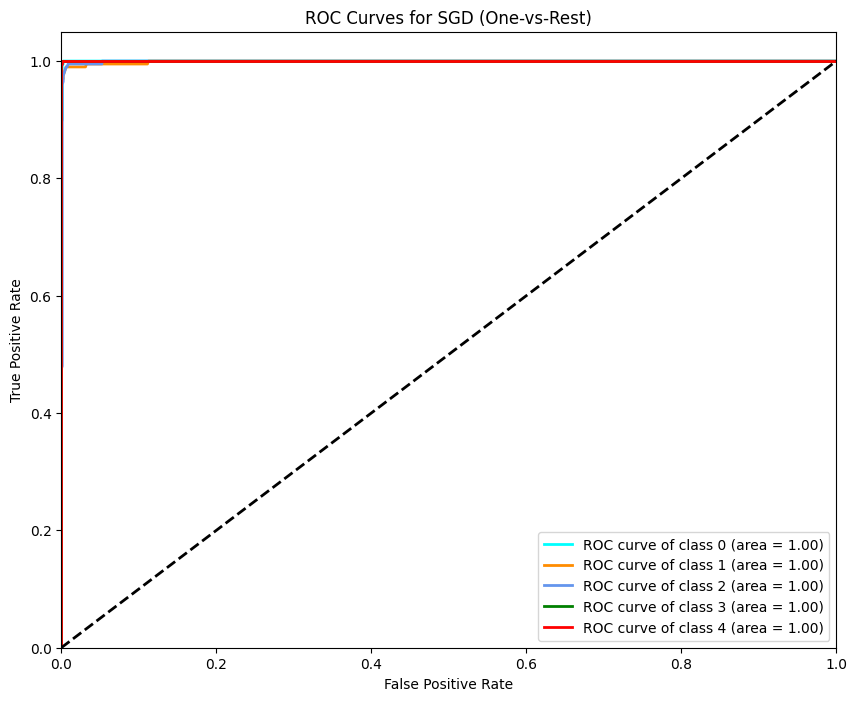


Average ROC-AUC score (One-vs-Rest): 0.9940 (±0.0037)


In [9]:

# ROC-AUC curves
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], best_sgd.predict_proba(X)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), best_sgd.predict_proba(X).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SGD (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Print average ROC-AUC score
roc_auc_scores = []
for train, test in cv.split(X, y):
    best_sgd.fit(X[train], y[train])
    y_score = best_sgd.predict_proba(X[test])
    roc_auc_scores.append(roc_auc_score(y_bin[test], y_score, multi_class='ovr'))

print(f"\nAverage ROC-AUC score (One-vs-Rest): {np.mean(roc_auc_scores):.4f} (±{np.std(roc_auc_scores):.4f})")

In [3]:
# Split the data into 80% train and 20% test
X = df_tfidf.drop(['num_label'], axis=1).values
y = df_tfidf['num_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

params = {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}

fin_sgd = SGDClassifier(**params)
fin_sgd.fit(X_train, y_train)

# Evaluate on test set
y_pred = fin_sgd.predict(X_test)
y_prob = fin_sgd.predict_proba(X_test)  # for probability estimates

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.94      0.82      0.88        40
           2       0.90      0.95      0.93        40
           3       0.95      0.88      0.91        40
           4       0.91      1.00      0.95        40

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200


ROC-AUC Score (One-vs-Rest): 0.9918

Confusion Matrix:
[[39  0  0  1  0]
 [ 1 33  4  1  1]
 [ 0  2 38  0  0]
 [ 2  0  0 35  3]
 [ 0  0  0  0 40]]


In [37]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

sample_size = 200  # Adjust based on your memory constraints
X_sample = resample(X_train, n_samples=sample_size, random_state=42, stratify=y_train[:sample_size])

explainer = shap.LinearExplainer(fin_sgd, X_sample, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test[:200])


/home/eigentlichervogel/generic-ml/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


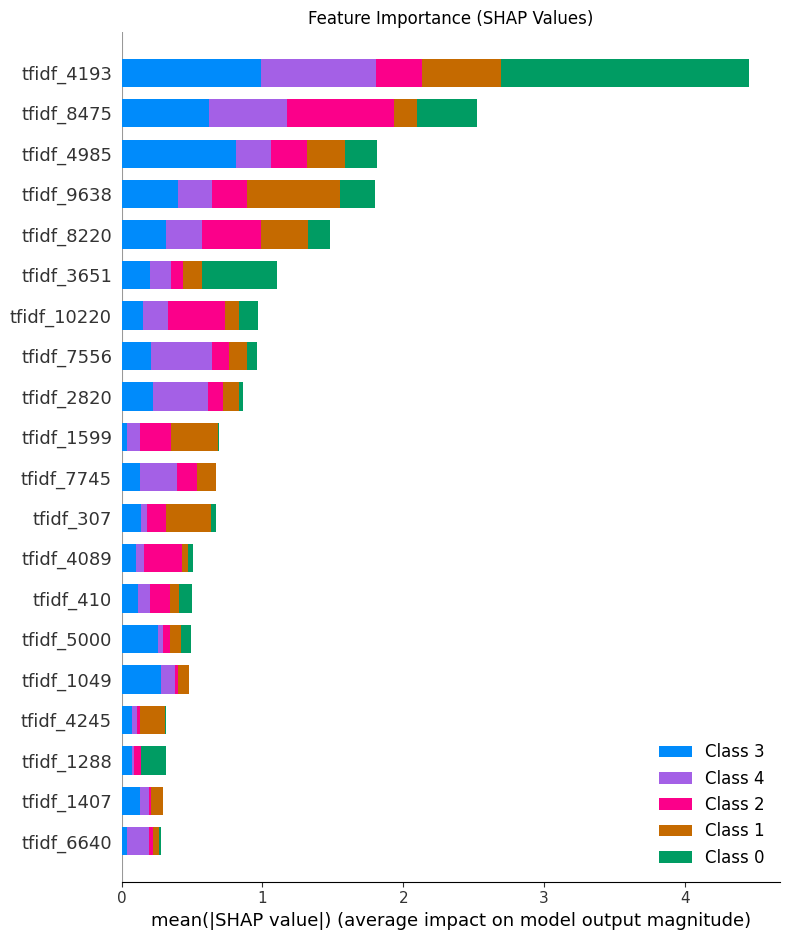

In [55]:

#Beeswarm Plot (summary of feature importance)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test[:200], feature_names=df_tfidf.columns[:-1], 
                  class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
                  plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()


<class 'numpy.ndarray'>
(200, 11694, 5)
(5,)
(11694,)
11695
11694
Feature names length: 11694


In [53]:
import shap

# Choose instance and class
instance_idx = 0   # First test sample
class_idx = 0      # First class (e.g., Class 0)

# Get SHAP values for ONE instance and ONE class
shap_val_single = shap_values[class_idx][instance_idx]  # Shape: (n_features,)

# Get feature values for the same instance
feature_val_single = X_test[instance_idx]               # Shape: (n_features,)
print(type(shap_values))  # List or np.array?
print(np.array(shap_values).shape)

shap_val_single = shap_values[class_idx][instance_idx]

print(shap_val_single.shape)
print(feature_val_single.shape)

print(len(df_tfidf.columns[:-1]))
print(len(feature_val_single))
print("Feature names length:", len(df_tfidf.columns[:-1]))


<class 'numpy.ndarray'>
(200, 11694, 5)
(5,)
(11694,)
11694
11694
Feature names length: 11694


DimensionError: Length of features is not equal to the length of shap_values!